In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from enum import Enum

class BinaryOp(Enum):
    ADD = "+"
    SUB = "-"
    MUL = "*"
    DIV = "/"
    POW = "^"

    def evaluate(self, lhs, rhs):
        if self == BinaryOp.ADD:
            return lhs + rhs
        elif self == BinaryOp.SUB:
            return lhs - rhs
        elif self == BinaryOp.MUL:
            return lhs * rhs
        elif self == BinaryOp.DIV:
            return lhs / rhs
        elif self == BinaryOp.POW:
            return np.power(lhs, rhs)
        else:
            raise RuntimeError("Invalid binary operator.")
        
class UnaryOp(Enum):
    NEG = "-"
    EXP = "exp"
    SIN = "sin"
    COS = "cos"
    TAN = "tan"
    ASIN = "asin"
    ACOS = "acos"
    ATAN = "atan"
    SQRT = "sqrt"

    def evaluate(self, value):
        if self == UnaryOp.NEG:
            return -value
        elif self == UnaryOp.EXP:
            return np.exp(value)
        elif self == UnaryOp.SIN:
            return np.sin(value)
        elif self == UnaryOp.COS:
            return np.cos(value)
        elif self == UnaryOp.TAN:
            return np.tan(value)
        elif self == UnaryOp.ASIN:
            return np.arcsin(value)
        elif self == UnaryOp.ACOS:
            return np.arccos(value)
        elif self == UnaryOp.ATAN:
            return np.arctan(value)
        elif self == UnaryOp.SQRT:
            return np.sqrt(value)
        else:
            raise RuntimeError("Invalid unary operator.")

class Expression(object):
    def evaluate(self, context):
        raise NotImplemented
    
    def simplify(self):
        raise NotImplemented
    
    def __str__(self) -> str:
        raise NotImplemented

class ConstantExpression(Expression):
    def __init__(self, value) -> None:
        super().__init__()
        self.value = value

    def evaluate(self, context):
        return self.value
    
    def simplify(self):
        return self
    
    def __str__(self) -> str:
        return str(self.value)
    
class VariableExpression(Expression):
    def __init__(self, name: str) -> None:
        super().__init__()
        self.name = name

    def evaluate(self, context):
        return context[self.name]
    
    def simplify(self):
        return self
    
    def __str__(self) -> str:
        return self.name
    
class UnaryExpression(Expression):
    def __init__(self, op: UnaryOp, expr: Expression) -> None:
        super().__init__()
        self.op = op
        self.expr = expr

    def evaluate(self, context):
        return self.op.evaluate(self.expr.evaluate(context))
    
    def simplify(self):
        expr = self.expr.simplify()

        if isinstance(expr, ConstantExpression):
            return ConstantExpression(self.op.evaluate(expr.evaluate(None)))

        return UnaryExpression(self.op, expr)
    
    def __str__(self) -> str:
        return f"{self.op.value}({self.expr})"

class BinaryExpression(Expression):
    def __init__(self, op: BinaryOp, lhs: Expression, rhs: Expression) -> None:
        super().__init__()
        self.op = op
        self.lhs = lhs
        self.rhs = rhs

    def evaluate(self, context):
        lhs_value = self.lhs.evaluate(context)
        rhs_value = self.rhs.evaluate(context)
        return self.op.evaluate(lhs_value, rhs_value)
    
    def simplify(self):
        lhs = self.lhs.simplify()
        rhs = self.rhs.simplify()

        if isinstance(lhs, ConstantExpression) and isinstance(rhs, ConstantExpression):
            return ConstantExpression(self.op.evaluate(lhs.evaluate(None), rhs.evaluate(None)))

        return BinaryExpression(self.op, lhs, rhs)
    
    def __str__(self) -> str:
        return f"({self.lhs} {self.op.value} {self.rhs})"


In [3]:
expr = BinaryExpression(BinaryOp.ADD, ConstantExpression(np.array(5)), ConstantExpression(np.array(4)))
print(expr.evaluate(None))
print(expr)
print(isinstance(expr, BinaryExpression))
print(expr is ConstantExpression)

9
(5 + 4)
True
False


In [4]:
def random_binary_expression(depth: int, options):
    if depth == 0:
        if np.random.choice(2) == 0:
            return ConstantExpression(np.random.randint(1, 10))
        else:
            return VariableExpression("x")
    else:
        op = np.random.choice(options["BINARY_OPERATORS"])
        expr = BinaryExpression(op, random_binary_expression(depth - 1, options), random_binary_expression(depth - 1, options))
        if np.random.choice(5) == 0: # why 5 + increase depth
            op = np.random.choice(options["UNARY_OPERATORS"])
            expr = UnaryExpression(op, expr)
        return expr

tan(((x + x) * sin((3 * x))))


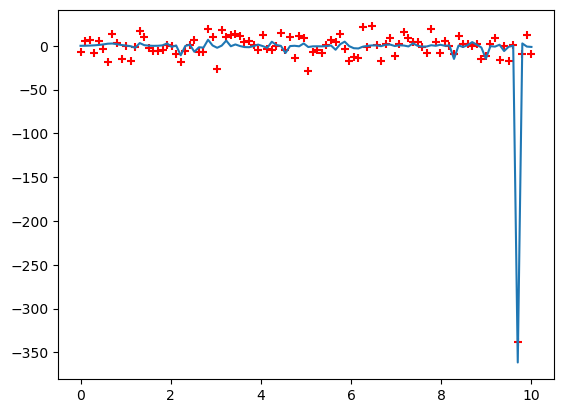

In [33]:
options = { "BINARY_OPERATORS": [ BinaryOp.ADD, BinaryOp.MUL ], "UNARY_OPERATORS": [ UnaryOp.SQRT, UnaryOp.SIN, UnaryOp.TAN ] }
expr = random_binary_expression(2, options).simplify()
print(expr)
N = 100
X = np.linspace(0, 10, N)
Y = expr.evaluate({ "x": X })
plt.plot(X, Y)
plt.scatter(X, Y + np.random.normal(size=np.shape(X)[0], scale=np.std(Y) * 0.3), marker='+', color='red')

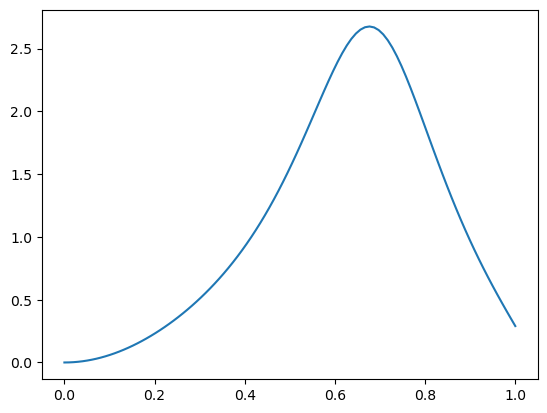

In [34]:
expr_cible = expr
X = np.linspace(0, 1, N)
Y = expr.evaluate({ "x": X })
plt.plot(X, Y)

In [37]:
options = { "BINARY_OPERATORS": [ BinaryOp.ADD, BinaryOp.MUL ], "UNARY_OPERATORS": [ UnaryOp.SQRT, UnaryOp.SIN, UnaryOp.TAN ] }

expr_list = []
error_list = []
for i in range(10000):
    expr = random_binary_expression(2, options)
    
    error = np.sum((expr.evaluate({ "x": X }) - expr_cible.evaluate({"x" : X}))**2)
    if error < np.inf :
        expr_list.append(expr)
        error_list.append(error)

/tmp/ipykernel_2843/114956546.py:53: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(value)


tan(((x + x) * sin((3 * x))))
((1 * x) + sin((x * 3)))


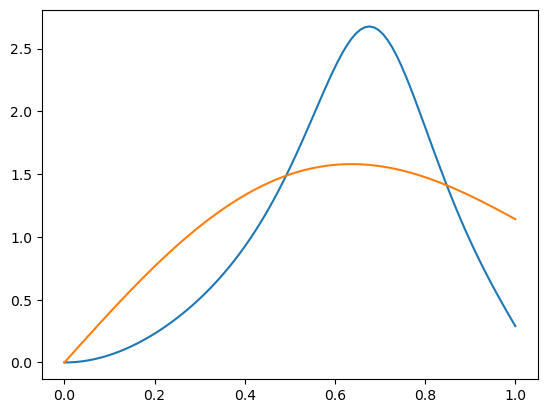

In [38]:
print(expr_cible)
print(expr_list[np.argmin(error_list)])

plt.figure()
plt.plot(X, Y)
plt.plot(X, expr_list[np.argmin(error_list)].evaluate({"x" : X}))

In [14]:
try :
    expr_list[426].evaluate({ "x": X })
except:
    print("O")

/tmp/ipykernel_2843/114956546.py:53: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(value)


In [10]:
np.sum(expr_list[324].evaluate({ "x": X })) < np.inf

True

In [12]:
np.argmin(error_list)

426